# Manipulating font data

By [Allison Parrish](https://www.decontextualize.com/)

This is a short notebook showing some techniques for loading data from TrueType/OpenType font files with [freetype-py](https://freetype-py.readthedocs.io/en/latest/) and then doing weird things with it using [Bezmerizing](https://github.com/aparrish/bezmerizing/). Make sure you've gone through these introductory notebooks before proceeding:

* [Lines and asemic writing](lines-and-asemic-vsketch.ipynb)
* [Polylines are just numbers](polylines-are-just-numbers.ipynb) (optional but helpful)

We'll start with some introductory information about typography and font files.

## Typography terminology

First off, there are a number of terms that describe certain distances between parts of letterforms:

![Diagram of typography line terms](http://comptypo.decontextualize.com/public/images/800px-Typography_Line_Terms.svg.png)

Units of measurement:

* Point (1/72nd of an inch)
* Em (the width of a capital 'M' in a font)
* Pixel (the distance from one side of a pixel in a display to the other; may
  differ horizontally and vertically; some LCDs can have meaningful 'sub-pixel'
  addressing; "pixel" can mean something different on high-density displays)

Letter forms by their nature are analog (formed from continuous curves). *Rasterization* is the process of "sampling" the analog curves to a grid, for (e.g.) display on a screen.

## Components of TrueType/OpenType fonts

The most common digital formats for fonts are TrueType (`.ttf`) and OpenType (`.otf`), two closely related standards defined and implemented by [a dizzying amalgamation of Adobe, Apple and Microsoft during the 1990s and early
2000s](https://en.wikipedia.org/wiki/OpenType#History). Both are variants of the [SFNT format](https://en.wikipedia.org/wiki/SFNT) and share many of the same abstractions but differ in many particulars. I attempt to explain the important components of both formats in this section.

### Characters and glyphs

A text is often said to be made up of a string of characters. A character is the basic unit of writing: they're what you learn when you learn to write.

The most important part of a font file is the "glyphs," which are the individual, distinct marks that the font can produce. In many cases, there is a one-to-one correspondence between glyphs and characters (e.g., the glyph *c*
represents the character `c`) but some glyphs represent multiple characters (e.g., ligatures like ﬁ) and some characters may be represeted by more than one glyph (stylistic or contextual variants, e.g., the character `s` in early modern English, represented as *ſ* when found in the middle of a word, and *s* when found at the end).

For this reason, TTF/OTF fonts include information on how to map characters to glyphs. The most straightforward way to do this is with the [cmap table](https://docs.microsoft.com/en-us/typography/opentype/spec/cmap), which links a character (given as, e.g., Unicode code points) to a numbered glyph in
the font. [Substitution features](http://ilovetypography.com/OpenType/opentype-features.html) in OpenType allow the font designer to specify that certain sequences of characters should be represented with particular glyphs (like ligatures, but this feature also be creatively misused; see [Sans Bullshit Sans](https://pixelambacht.nl/2015/sans-bullshit-sans/) and [Doggy](https://www.swiss-miss.com/2012/09/doggy.html)). A font file may also specify other visual aspects of how the text should be rendered, like kerning (adjusting the horizontal and/or vertical space between pairs or longer sequences of characters), which in OpenType is specified in the [GPOS table](https://docs.microsoft.com/en-us/typography/opentype/spec/gpos).

Another aspect of appearance often specified in a font is [hinting](https://en.wikipedia.org/wiki/Font_hinting), which specifies how the vector data in the font should be adjusted during the rasterization process (i.e., displaying on a pixel-based screen), to ensure that the important parts of each glyph are displayed even when interpolated. The TrueType font format has [an absurdly sophisticated system for font hinting](https://docs.microsoft.com/en-us/typography/truetype/hinting), including a Turing-complete programming language, which has led to some [truly
spectacular security vulnerabilities](https://www.youtube.com/watch?v=jioFhWanFxU).

### Shape information

In TrueType and OpenType fonts, the shape of a glyph is specified using data in an sfnt table (called either `glyf` or `CFF `). The point of the data is to define the lines and curves that form the outline of the shapes. The actual formats of these tables are quite frankly baroque and overly complicated; see the [`glyf` specification](https://developer.apple.com/fonts/TrueType-Reference-Manual/RM06/Chap6glyf.html) and the [`CFF `
specification](https://docs.microsoft.com/en-us/typography/opentype/spec/cff). For our purposes, it's not worth talking about the details, since the library we'll be using to parse the font files will smooth everything over for us.

In general, the outline of a glyph is comprised of a series of one or more contours (shapes), which are in turn comprised of lines and curves (with 2D coordinates). In TrueType and OpenType fonts, the start/end positions are
integers on a grid whose resolution is defined by the font itself (e.g., 2048 units per em), with the origin generally at the lower left-hand corner of the glyph.

This illustration from the [FreeType documentation](https://www.freetype.org/freetype2/docs/glyphs/index.html) names
some of the metrics associated with a (horizontal) glyph. For example, the character's *bearing* is a measure of how far from the origin the glyph is; the *advance* of a character controls how much the "pen" should be moved forward
after drawing the character; this may be different from the character's *width*.

![OpenType metrics diagram](http://comptypo.decontextualize.com/public/images/metrics.png)

### Curves

A contour specification consists of lines and curves. Representing a line as data is very easy; you just need to indicate the coordinates of the start and end of the segment. Representing a curve is a little bit more difficult, and there are multiple strategies for accomplishing this. The most common way to represent curves is as [Bézier
curves](https://en.wikipedia.org/wiki/B%C3%A9zier_curve). Named after French engineer [Pierre Bézier](https://en.wikipedia.org/wiki/Pierre_B%C3%A9zier), who used the math behind the curve in industrial design in the 1960s, a Bézier curve consists of two *anchor points* and a series of *control points*.  The anchor points define the beginning and ending of the curve, and the control points define the extent of the curvature. A Bézier curve with one control point is called *quadratic* and one with two control points is called *cubic*. Higher order curves are possible, but because the use of cubic curves is so widespread in software, the term "Bézier" is often used specifically to mean *cubic* Bézier curves. (This reflects the usage in, e.g., p5.js: see [bezier()](https://p5js.org/reference/#/p5/bezier) and [quadraticVertex()](https://p5js.org/reference/#/p5/quadraticVertex) in the
documentation.)

The following demo lets you play with a cubic Bézier's anchor and control points: [(Cubic) Bezier curve demo](https://editor.p5js.org/allison.parrish/sketches/H1QQ3Nt67)

And the demo below does the same for a quadratic curve: [Quadratic curve demo](https://editor.p5js.org/allison.parrish/sketches/HysPl9FT7)

Here's [a helpful introduction to the math behind Bézier curves](https://pomax.github.io/bezierinfo/), how they're represented as data and how to efficiently rasterize them. (You don't need to read or understand all of this in order to make use of Bézier curves, but it's helpful to read at least the first few sections.) The author of that tutorial has also made a [wonderful library for working with Bézier curves in JavaScript](https://pomax.github.io/bezierjs/). 

The distinction between quadratic and cubic curves is important, because TrueType fonts (with `glyf` tables) *only* support quadratic curves, while OpenType fonts (specifically those that use the `CFF ` table) make use of cubic curves. If you want to be able to draw glyphs from either format, you have to be able to draw both kinds of curves.

### Counters and cutouts

Many glyph outlines consist of more than one contour: the letter `j` for example has a contour for the body of the letter and a separate (non-overlapping) contour for the dot.

Additionally, some glyph outlines have have closed [counters](https://en.wikipedia.org/wiki/Counter_(typography)): contours of the glyph that are completely enclosed within another contour. (The "hole" in the letter `O` is an example; a capital `B` has two counters.) Some glyph outlines, like `®`, have contours within contours within contours!

So the question arises: in a glyph outline, how do you know which contours should be filled in, and which should be "cut out"? (Otherwise stated: how do you know which points are "inside" the letter and should be filled in, and
which points are "outside" the letter and should be left blank?)

This is one of the trickier parts of rendering a glyph. TrueType `glyf` fonts use one strategy: if the points in a contour are defined in a clockwise fashion, then the shape should be filled; if they're defined in a counter-clockwise fashion, then the shape should be cut out. In OpenType `CFF ` fonts, contours are considered cutouts if they're contained inside an odd number of other paths. ([Source](https://github.com/opentypejs/opentype.js/issues/347).) In either case, finding out whether a contour should be cut out or filled in depends on doing some math on the points and curves of the contours themselves.

### Variable fonts

Recent versions of the OpenType standard include support for ["variable" fonts](https://simoncozens.github.io/fonts-and-layout/opentype.html#opentype-font-variations). Variable fonts contain multiple "masters" (i.e., different versions of the same glyphs), alongside information about how to interpolate between the points in those masters. The end goal of variable fonts is to make it possible to dynamically adjust (e.g.) the weight of a font (without having to include separate font data for each weight). As of this writing, support for variable fonts remains incomplete (even in some web browsers), and the library we're using to work with TrueType/OpenType files (sadly) does not support variable fonts. But it's worth knowing about! This [Variable Fonts website](https://v-fonts.com/) has a ton of variable fonts you can play around with to get an idea for how they work.

## Code preliminaries

You'll need to install [Bezmerizing](https://github.com/aparrish/bezmerizing/) and [vsketch](https://github.com/abey79/vsketch), as explained in previous notebooks in this series. You'll also need to install [freetype-py](https://github.com/rougier/freetype-py/), the Python bindings for [Freetype](https://freetype.org/). Install like so:

In [1]:
import sys
!{sys.executable} -m pip install freetype-py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 11.9 MB/s eta 0:00:0000:0100:01


Whew! With all of that in mind, we can start programming. Before we begin, some preliminary imports from vsketch and Bezmerizing:

In [1]:
import vsketch
from bezmerizing import Polyline, PolylineList, QuadraticBezier, Bezier as CubicBezier
import numpy as np

And some functions from `numpy` which we'll use for generating random numbers.

In [2]:
from numpy.random import uniform, normal, choice

### Our assumptions

All of these are bad assumptions (see [Ramsey Nasser's take](https://increment.com/programming-languages/unplain-text-primer-on-non-latin/), inter alia), but we're making them in order to explain the basics of how fonts (and Freetype) work. 

* Assumption 1: Glyphs and characters are in a one-to-one relationship (so: no ligatures)
* Assumption 2: We can lay out text by laying out the glyphs for each Unicode code point next to each other.
* Assumption 3: Text is laid out from left to right.

If you want to actually do text layout, you might consider pairing Freetype with [Harfbuzz](https://github.com/harfbuzz/harfbuzz) ([Python bindings here](https://github.com/harfbuzz/uharfbuzz).

## Opening a font file with FreeType

Our goal is to get at glyph data in a font. To do this, you need to create a Freetype `Face` object. This is our basic interface for accessing information about the font and the glyph data in the font.

In [3]:
import freetype

The examples in this notebook are only tested to work with TrueType fonts! Pick a `.tff` file and put it in the same directory as this notebook and then put the filename in here:

In [4]:
face = freetype.Face("./NotoSans-Regular.ttf")

After having loaded the file, we get access to some top-level information about the font, such as its family name and style:

In [5]:
face.family_name.decode('ascii')

'Noto Sans'

In [6]:
face.style_name.decode('ascii')

'Regular'

Note that these names are stored in the font file as ASCII text; the Freetype Python bindings return them as byte strings, so we need to use `.decode()` to turn them into actual strings.

The `Face` object also has useful information about the font's geometry. Most important is `.units_per_EM`, which tells us the relationship between the font's internal coordinate space and what those coordinates should translate to on-screen and on the page. (More about this below.)

In [7]:
face.units_per_EM

1000

The `.descender` attribute tells us the lowest Y coordinate of any character with a descender:

In [8]:
face.descender

-293

And the `.ascender` attribute tells us the highest Y coordinate of any character with an ascender:

In [9]:
face.ascender

1069

The `.get_chars()` method returns a list of all of the characters in the font, along with the associated glyph ID. (There is actually a many-to-many relationship between characters and glyphs in OpenType-style fonts, given the existence of ligatures and font shaping. However, for our purposes, we'll briefly pretend that every character has only one associated glyph. This assumption is, better or worse, supported at the level of the Freetype library itself.) In the cell below, I make a dictionary that makes characters to their corresponding indexes.

In [20]:
all_chars = {chr(ch): idx for ch, idx in face.get_chars()}

The following cell shows all of the characters in this font:

In [23]:
''.join(all_chars.keys())

'\x00\r !"#$%&\'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\\]^_`abcdefghijklmnopqrstuvwxyz{|}~\xa0¡¢£¤¥¦§¨©ª«¬\xad®¯°±²³´µ¶·¸¹º»¼½¾¿ÀÁÂÃÄÅÆÇÈÉÊËÌÍÎÏÐÑÒÓÔÕÖ×ØÙÚÛÜÝÞßàáâãäåæçèéêëìíîïðñòóôõö÷øùúûüýþÿĀāĂăĄąĆćĈĉĊċČčĎďĐđĒēĔĕĖėĘęĚěĜĝĞğĠġĢģĤĥĦħĨĩĪīĬĭĮįİıĲĳĴĵĶķĸĹĺĻļĽľĿŀŁłŃńŅņŇňŉŊŋŌōŎŏŐőŒœŔŕŖŗŘřŚśŜŝŞşŠšŢţŤťŦŧŨũŪūŬŭŮůŰűŲųŴŵŶŷŸŹźŻżŽžſƀƁƂƃƄƅƆƇƈƉƊƋƌƍƎƏƐƑƒƓƔƕƖƗƘƙƚƛƜƝƞƟƠơƢƣƤƥƦƧƨƩƪƫƬƭƮƯưƱƲƳƴƵƶƷƸƹƺƻƼƽƾƿǀǁǂǃǄǅǆǇǈǉǊǋǌǍǎǏǐǑǒǓǔǕǖǗǘǙǚǛǜǝǞǟǠǡǢǣǤǥǦǧǨǩǪǫǬǭǮǯǰǱǲǳǴǵǶǷǸǹǺǻǼǽǾǿȀȁȂȃȄȅȆȇȈȉȊȋȌȍȎȏȐȑȒȓȔȕȖȗȘșȚțȜȝȞȟȠȡȢȣȤȥȦȧȨȩȪȫȬȭȮȯȰȱȲȳȴȵȶȷȸȹȺȻȼȽȾȿɀɁɂɃɄɅɆɇɈɉɊɋɌɍɎɏɐɑɒɓɔɕɖɗɘəɚɛɜɝɞɟɠɡɢɣɤɥɦɧɨɩɪɫɬɭɮɯɰɱɲɳɴɵɶɷɸɹɺɻɼɽɾɿʀʁʂʃʄʅʆʇʈʉʊʋʌʍʎʏʐʑʒʓʔʕʖʗʘʙʚʛʜʝʞʟʠʡʢʣʤʥʦʧʨʩʪʫʬʭʮʯʰʱʲʳʴʵʶʷʸʹʺʻʼʽʾʿˀˁ˂˃˄˅ˆˇˈˉˊˋˌˍˎˏːˑ˒˓˔˕˖˗˘˙˚˛˜˝˞˟ˠˡˢˣˤ˥˦˧˨˩˪˫ˬ˭ˮ˯˰˱˲˳˴˵˶˷˸˹˺˻˼˽˾˿̴̵̶̷̸̡̢̧̨̛̖̗̘̙̜̝̞̟̠̣̤̥̦̩̪̫̬̭̮̯̰̱̲̳̹̺̻̼͇͈͉͍͎̀́̂̃̄̅̆̇̈̉̊̋̌̍̎̏̐̑̒̓̔̽̾̿̀́͂̓̈́͆͊͋͌̕̚ͅ͏͓͔͕͖͙͚͐͑͒͗͛ͣͤͥͦͧͨͩͪͫͬͭͮͯ͘͜͟͢͝͞͠͡ͰͱͲͳʹ͵Ͷͷͺͻͼͽ;Ϳ΄΅Ά·ΈΉΊΌΎΏΐΑΒΓΔΕΖΗΘΙΚΛΜΝΞΟΠΡΣΤΥΦΧΨΩΪΫάέήίΰαβγδεζηθικλμνξοπρςστυφχψωϊϋόύώϏϐϑϒϓϔϕϖϗϘϙϚϛϜϝϞϟϠϡϰϱϲϳϴϵ϶ϷϸϹϺϻϼϽϾϿЀЁЂЃЄЅІЇЈЉЊЋЌЍЎЏАБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯа

### Advances

Each glyph has an "advance," which is the amount that the cursor should move forward after the character has been drawn. The code below makes a dictionary that maps each Unicode codepoint in the font to its corresponding advance value:

In [24]:
char2adv = {chr(ch): face.get_advance(face.get_char_index(ch), freetype.FT_LOAD_NO_SCALE)
            for ch, idx in face.get_chars()}

Now we can check the values for individual characters. We see that the advance for an exclamation point...

In [25]:
char2adv['!']

269

... is smaller than the advance for the letter 'W':

In [26]:
char2adv['W']

930

Which is exactly what we'd expect for a proportional font.

## Glyph decomposition and coordinate spaces

The Freetype library gives us access to the underlying geometry of the glyph as a sequence of points, contour indices, and tags. You can read more about this data format [in the original Freetype library](https://freetype.org/freetype2/docs/reference/ft2-outline_processing.html#ft_outline) or the [freetype-py documentation](https://freetype-py.readthedocs.io/en/latest/outline.html). There's also [an example in the freetype-py repository](https://github.com/rougier/freetype-py/blob/master/examples/glyph-vector.py) of using this data to extract geometry of glyphs.

However, I think the easiest way to get the actual outline information from FreeType is to call the outline's `decompose` method, which works via callbacks. The library parses the points of the geometry for you, and calls a fuction that you write that corresponds to individual movement commands. An example of a function for decomposing a glyph outline is below:

In [27]:
def show_decomp(face, ch):
    # callbacks
    def move_to(dest, ctx):
        print(f"move to ({dest.x}, {dest.y})")
    def line_to(dest, ctx):
        print(f"line to ({dest.x}, {dest.y})")
    def quad_bez(ctrl, dest, ctx):
        print(f"quad bezier to ({dest.x}, {dest.y}), control pt ({ctrl.x}, {ctrl.y})")
    def cubic_bez(ctrl1, ctrl2, dest, ctx):
        print(f"cubic bezier to ({dest.x}, {dest.y}), control pts ({ctrl1.x}, {ctrl1.y}), ({ctrl1.x}, {ctrl2.y})")
    face.load_char(ch, freetype.FT_LOAD_DEFAULT | freetype.FT_LOAD_NO_BITMAP)
    face.glyph.outline.decompose(None,
                                 move_to=move_to,
                                 line_to=line_to,
                                 conic_to=quad_bez,
                                 cubic_to=cubic_bez)

This function just prints out a description of each movement. You can interpret these as "commands" that let you draw the glyph's outline.

In [28]:
show_decomp(face, '-')

move to (40, 229)
line to (40, 307)
line to (282, 307)
line to (282, 229)
line to (40, 229)


Each 'move to' command essentially begins a new contour. For example, `o` has two contours:

In [29]:
show_decomp(face, 'o')

move to (551, 269)
quad bezier to (483, 63), control pt (551, 136)
quad bezier to (301, -10), control pt (416, -10)
quad bezier to (174, 22), control pt (230, -10)
quad bezier to (87, 117), control pt (119, 55)
quad bezier to (55, 269), control pt (55, 180)
quad bezier to (121, 474), control pt (55, 402)
quad bezier to (304, 546), control pt (188, 546)
quad bezier to (432, 513), control pt (376, 546)
quad bezier to (519, 419), control pt (488, 481)
quad bezier to (551, 269), control pt (551, 358)
move to (146, 269)
quad bezier to (183, 118), control pt (146, 174)
quad bezier to (303, 63), control pt (221, 63)
quad bezier to (422, 118), control pt (384, 63)
quad bezier to (460, 269), control pt (460, 174)
quad bezier to (422, 418), control pt (460, 364)
quad bezier to (302, 472), control pt (384, 472)
quad bezier to (183, 418), control pt (220, 472)
quad bezier to (146, 269), control pt (146, 364)


The following function actually draws the outline, using a `vsketch` object that you pass in. Note that I've flipped the Y coordinates! This is because Vsketch interprets positive Y coordinates as moving downward, while font outline data is designed such that positive Y coordinates move upward. (Without this little tweak, we'd be drawing the characters upside-down.)

In [30]:
def draw_decomp(face, vsk, ch):
    # current cursor position
    ctx = {'x': 0, 'y': 0}
    
    def move_to(dest, ctx):
        ctx['x'] = dest.x
        ctx['y'] = dest.y
        
    def line_to(dest, ctx):
        vsk.line(ctx['x'], -ctx['y'], dest.x, -dest.y)
        ctx['x'] = dest.x
        ctx['y'] = dest.y
        
    def quad_bez(ctrl, dest, ctx):
        # convert quad bezier to polyline
        pline = QuadraticBezier([ctx['x'], -ctx['y']],
                                [ctrl.x, -ctrl.y],
                                [dest.x, -dest.y]).to_polyline(20)
        vsk.polygon(pline)
        ctx['x'] = dest.x
        ctx['y'] = dest.y
        
    def cubic_bez(ctrl1, ctrl2, dest, ctx):
        # convert cubic bezier to polyline
        pline = CubicBezier([ctx['x'], -ctx['y']],
                            [ctrl1.x, -ctrl1.y],
                            [ctrl2.x, -ctrl2.y],
                            [dest.x, dest.y]).to_polyline(20)
        ctx['x'] = dest.x
        ctx['y'] = dest.y
        
    face.load_char(ch, freetype.FT_LOAD_DEFAULT | freetype.FT_LOAD_NO_BITMAP)
    face.glyph.outline.decompose(ctx,
                                 move_to=move_to,
                                 line_to=line_to,
                                 conic_to=quad_bez,
                                 cubic_to=cubic_bez)

Displayed to the screen:

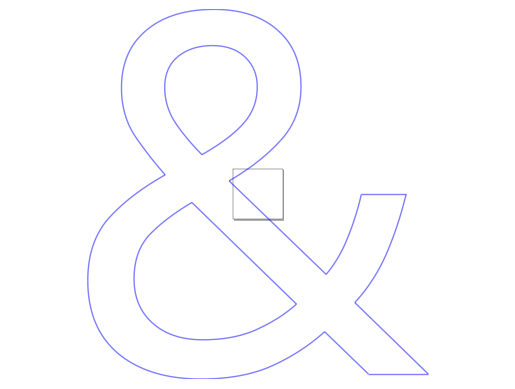

In [31]:
vsk = vsketch.Vsketch()
vsk.size("100mm", "100mm")
vsk.scale(f"1mm")
draw_decomp(face, vsk, "&")
vsk.display()

Why is it so big, though? Coordinates in fonts are given in *font units*, whose density can be ascertained with the `.units_per_EM` attribute of the font face:

In [32]:
face.units_per_EM

1000

That means that there are this many "font units" in an *em* (usually the same as the width of the letter `M` in the font). To draw a glyph at a size that we want, we need to divide that size by this density and scale to that value. For example, to make this glyph 100mm wide:

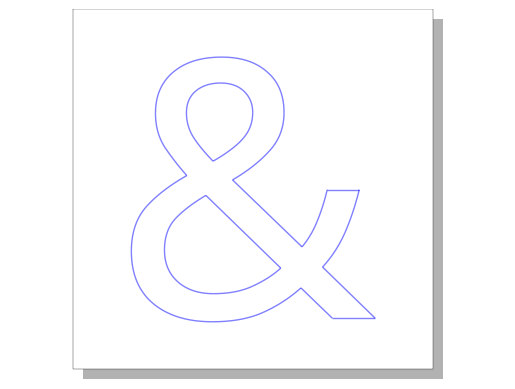

In [33]:
vsk = vsketch.Vsketch()
vsk.size("100mm", "100mm")
vsk.scale(f"1mm")
with vsk.pushMatrix():
    vsk.scale(100 / face.units_per_EM)
    draw_decomp(face, vsk, "&")
vsk.display()

If we wanted to think in points rather than millimeters (as is typical for fonts), the easiest way would be to set our initial scale to `1pt` instead of `1mm`. In the example below, I draw the ampersand at 72pt (equivalent to 1"):

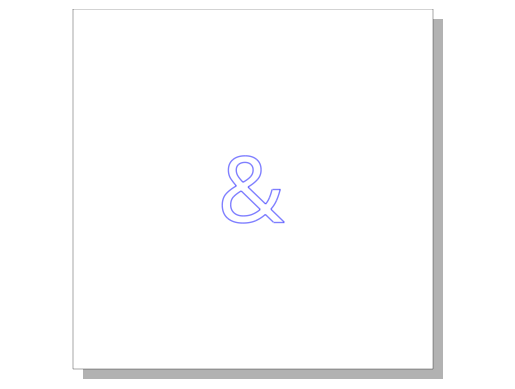

In [34]:
vsk = vsketch.Vsketch()
vsk.size("100mm", "100mm")
vsk.scale(f"1pt")
with vsk.pushMatrix():
    vsk.scale(72 / face.units_per_EM)
    draw_decomp(face, vsk, "&")
vsk.display()

### Example: Reinterpreting font commands

In the example below, instead of drawing the shape that corresponds to the instruction, I instead draw a different shape at the same location. For `line_to` commands, I draw a circle whose center is the midpoint of the line to be drawn, and whose diameter is the same length as the line. For curves, I draw a polyline with the source, destination, and control points.

In [35]:
import math
def draw_reinterpret(face, vsk, ch):
    # current cursor position
    ctx = {'x': 0, 'y': 0}
    
    def move_to(dest, ctx):
        ctx['x'] = dest.x
        ctx['y'] = dest.y
        
    def line_to(dest, ctx):
        midx = (ctx['x'] + dest.x) / 2
        midy = (ctx['y'] + dest.y) / 2
        dist = math.dist([ctx['x'], ctx['y']], [dest.x, dest.y])
        vsk.stroke(1)
        vsk.circle(midx, -midy, radius=dist/2)
        ctx['x'] = dest.x
        ctx['y'] = dest.y
        
    def quad_bez(ctrl, dest, ctx):
        vsk.polygon([[ctx['x'], -ctx['y']],
                     [ctrl.x, -ctrl.y],
                     [dest.x, -dest.y]], close=True)
        ctx['x'] = dest.x
        ctx['y'] = dest.y
        
    def cubic_bez(ctrl1, ctrl2, dest, ctx):
        vsk.polygon([[ctx['x'], -ctx['y']],
             [ctrl1.x, -ctrl1.y],
             [ctrl2.x, -ctrl2.y],
             [dest.x, -dest.y]], close=True)
        ctx['x'] = dest.x
        ctx['y'] = dest.y
        
    face.load_char(ch, freetype.FT_LOAD_DEFAULT | freetype.FT_LOAD_NO_BITMAP)
    face.glyph.outline.decompose(ctx,
                                 move_to=move_to,
                                 line_to=line_to,
                                 conic_to=quad_bez,
                                 cubic_to=cubic_bez)

For example, a "biblically-accurate" `A`:

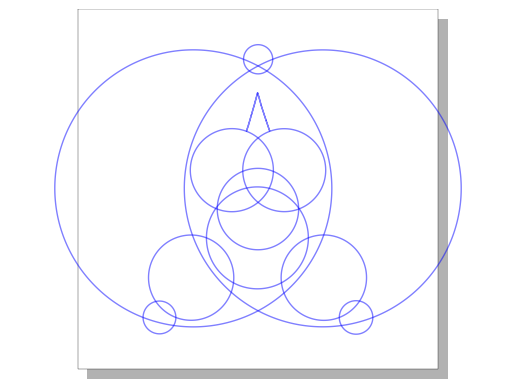

In [36]:
vsk = vsketch.Vsketch()
vsk.size("100mm", "100mm")
vsk.scale(f"1mm")
with vsk.pushMatrix():
    vsk.scale(100 / face.units_per_EM)
    draw_reinterpret(face, vsk, "A")
vsk.display()

## Convert glyph to list of polylines

The following function will convert a glyph to a list of polylines. I've added some comments to help you understand what's going on, but the basic gist is this: for every command, convert the shape that command draws to a polyline. Whenever there's a `move_to` command, that means that there is a new contour, and therefore a new polyline. (Note that this function automatically flips the coordinates so that Y increases downward instead of upward.)

In [37]:
def to_polylines(face, ch, resample_lines=False, samples_per=20):

    cp = []
    plines = []
    
    # if there are any segments in the current polyline,
    # add to the list of polylines and start a new polyline
    def move_to(dest, ctx):
        nonlocal cp
        if len(cp) > 0:
            plines.append(cp)
        cp = [[dest.x, -dest.y]]
        
    # append destination to the current polyline
    def line_to(dest, ctx):
        # resample lines so we have more points to play with
        if resample_lines:
            resampled = (Polyline([cp[-1], [dest.x, -dest.y]])
                         .resample(samples_per)
                         .vertices
                         .tolist())
            cp.extend(resampled[1:])
        else:
            cp.append([dest.x, -dest.y])
    
    # extend polyline with points from sampled bezier
    def quad_bez(ctrl, dest, ctx):
        pline = QuadraticBezier(cp[-1],
                                [ctrl.x, -ctrl.y],
                                [dest.x, -dest.y]).to_polyline(samples_per)
        cp.extend(pline[1:])
        
    # extend polyline with points from sampled bezier
    def cubic_bez(ctrl1, ctrl2, dest, ctx):
        pline = CubicBezier(cp[-1],
                            [ctrl1.x, -ctrl1.y],
                            [ctrl2.x, -ctrl2.y],
                            [dest.x, -dest.y]).to_polyline(20)
        cp.extend(pline[1:])
        
    face.load_char(ch, freetype.FT_LOAD_DEFAULT | freetype.FT_LOAD_NO_BITMAP)
    face.glyph.outline.decompose(None,
                                 move_to=move_to,
                                 line_to=line_to,
                                 conic_to=quad_bez,
                                 cubic_to=cubic_bez)
    
    # append whatever's leftover as a new polyline
    if len(cp) > 0:
        plines.append(cp)
        
    return plines

Here we can test it out:

In [38]:
to_polylines(face, '=')

[[[56, -416], [56, -487], [514, -487], [514, -416], [56, -416]],
 [[56, -217], [56, -288], [514, -288], [514, -217], [56, -217]]]

And indeed, through visual inspection of this list, we can see that we have two contours, both rectangles that are parallel to each other—just like we'd expect from `=`.

The code in the following cell will draw whatever character you'd like. It does this by looping over each contour in the list and drawing them as polygons:

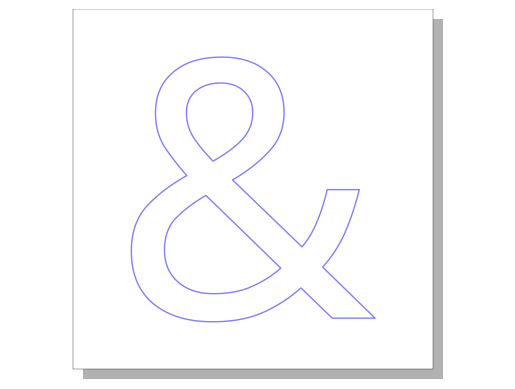

In [39]:
vsk = vsketch.Vsketch()
vsk.size("100mm", "100mm")
vsk.scale(f"1mm")
for pline in to_polylines(face, '&'):
    with vsk.pushMatrix():
        vsk.scale(100 / face.units_per_EM)
        vsk.polygon(pline)
vsk.display()

### Fills... don't work, whoops

Note that if you attempt to use vsketch's `.fill()` method to fill these shapes... it won't work! Or at least, not the way you expect.

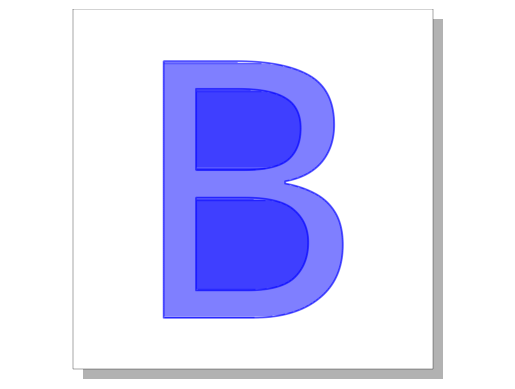

In [40]:
vsk = vsketch.Vsketch()
vsk.size("100mm", "100mm")
vsk.scale(f"1mm")
vsk.fill(1)
for pline in to_polylines(face, 'B'):
    with vsk.pushMatrix():
        vsk.scale(100 / face.units_per_EM)
        vsk.polygon(pline)
vsk.display()

The reason for this is that we have the *geometry* for the cutout contours, but there's nothing in the data that tells us whether a shape should be cut out or not! So all of the contours are filled: the outer contour of the B, and also the inner cutouts. Solving this problem is pretty tricky and we'll get to it later in the notebook. For now we'll just be playing with the outlines.

## Typesetting a string "by hand"

Using the `to_polylines()` function and the `char2adv` that we made earlier in the notebook, you can draw an entire string on the screen. The most simple technique to render a string of characters in a Roman-derived alphabet (like English):

* Keep track of the current cursor position.
* For each character in the string:
  * Draw the glyph associated with this character at the current cursor position.
  * Move the current cursor position to the right by the amount of the character's advance.

It should be noted that there are many important drawbacks to this approach:

* It only works with left-to-right writing
* Doesn't take into account kerning, ligatures, etc.

Even with simple left-to-right alphabets, there's more to think about than what we've implemented here. For example, this approach doesn't handle things like text alignment, line breaks, margins, indentation, etc. Still, this is as good a starting point as any.

> The task of taking a sequence of characters and turning it into a sequence of glyphs is called "text shaping," and it's a very complicated process, moreso for scripts like Arabic that rely heavily on ligatures. [HarfBuzz](https://en.wikipedia.org/wiki/HarfBuzz) is a well-known open source library for doing text shaping, and it has [Python bindings](https://github.com/harfbuzz/uharfbuzz).

### One character at a time

The code below implements this simple string layout procedure. It moves the pen by the character's advance on the x axis and draws the next character at the new position, using `translate()` to translate the path commands to the appropriate place.

In [43]:
s = "quartzy foxes"

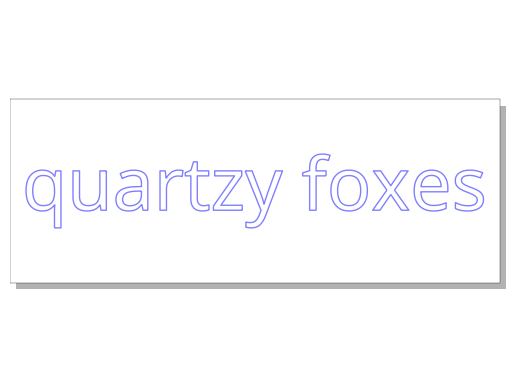

In [44]:
vsk = vsketch.Vsketch()
vsk.size("200mm", "75mm")
vsk.scale("1mm")
cx = 0
for ch in s:
    with vsk.pushMatrix():
        vsk.scale(30 / face.units_per_EM)
        vsk.translate(cx, 0)
        for pline in to_polylines(face, ch):
            vsk.polygon(pline)
        cx += char2adv[ch]
vsk.display()

Because we're drawing one character at a time, we can introduce some random variation to the character positions,  and scale:

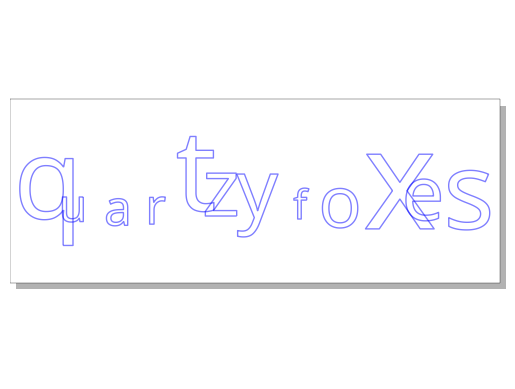

In [45]:
vsk = vsketch.Vsketch()
vsk.size("200mm", "75mm")
vsk.scale("1mm")
cx = 0
for ch in s:
    with vsk.pushMatrix():
        vsk.scale(30 / face.units_per_EM)
        vsk.translate(cx, 0)
        vsk.scale(uniform(0.5, 2))
        vsk.translate(0, uniform(-100, 100))
        for pline in to_polylines(face, ch):
            vsk.polygon(pline)
        cx += char2adv[ch]
vsk.display()

### Making one big list of polylines from a string

Another approach is to build a larger list of polylines that combines the polylines of each contour of each letter, and draw that instead. This has some interesting advantages that we'll look at later on. The following cell defines a function `combine_plines()` that takes a font and a string and returns a path that combines the paths for each character in the string:

In [46]:
from itertools import chain
def combine_plines(f, s, resample_lines=False):
    text_plines = []
    cx = 0
    for ch in s:
        glyph_pline = to_polylines(f, ch, resample_lines=resample_lines)
        translated = [Polyline(p).translate(cx, 0).vertices for p in glyph_pline]
        text_plines.extend(translated)
        cx += char2adv[ch]
    return text_plines

Call it like this:

In [47]:
qf_plines = combine_plines(face, "quartzy foxes")

The resulting list of polylines has a lot of contours:

In [48]:
len(qf_plines)

16

But you can draw it like any other list of polylines:

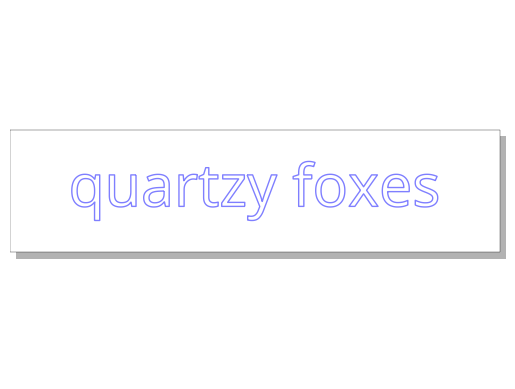

In [50]:
vsk = vsketch.Vsketch()
vsk.size("200mm", "50mm")
vsk.scale(f"1mm")
for pline in qf_plines:
    with vsk.pushMatrix():
        vsk.scale(24 / face.units_per_EM)
        vsk.polygon(pline)
vsk.display()

## DIY TextArt

Now that we have a big list of polylines, we can apply mathematical transformations on those polylines, just like we did in [the "polylines are just numbers" notebook](polylines-are-just-numbers.ipynb). Let's start off simple, and add some random noise to each point. We'll do this by looping over each polyline, looping over each point in those polylines, and adding a bit of noise:

In [51]:
plines = combine_plines(face, "quartzy foxes")
noisy = []
for pline in plines:
    mod_pline = []
    for pt in pline:
        mod_pline.append([pt[0] + uniform(-20, 20), pt[1] + uniform(-20, 20)])
    noisy.append(mod_pline)

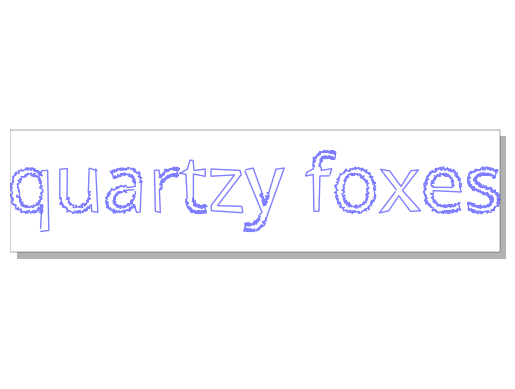

In [52]:
vsk = vsketch.Vsketch()
vsk.size("200mm", "50mm")
vsk.scale(f"1mm")
for pline in noisy:
    with vsk.pushMatrix():
        vsk.scale(32 / face.units_per_EM)
        vsk.polygon(pline)
vsk.display()

You'll notice that the curved parts of the characters get noisy in the above example, but the straight parts don't. That's because the procedure for converting characters to polylines samples at many points along Bezier curves, while straight lines are always only represented as two points. Fear not, however, as I added an option to `combine_plines()` to resample straight lines as well:

In [53]:
plines = combine_plines(face, "quartzy foxes", resample_lines=True)
noisy = []
for pline in plines:
    mod_pline = []
    for pt in pline:
        mod_pline.append([pt[0] + uniform(-20, 20), pt[1] + uniform(-20, 20)])
    noisy.append(mod_pline)

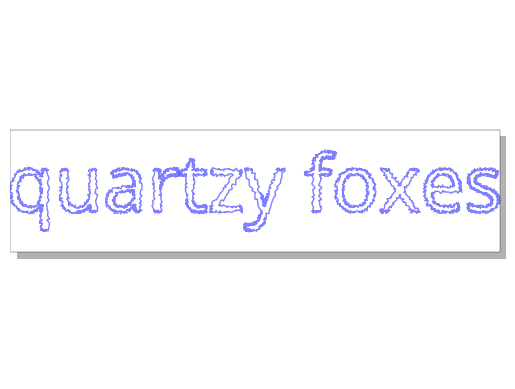

In [54]:
vsk = vsketch.Vsketch()
vsk.size("200mm", "50mm")
vsk.scale(f"1mm")
for pline in noisy:
    with vsk.pushMatrix():
        vsk.scale(32 / face.units_per_EM)
        vsk.polygon(pline)
vsk.display()

In the following example, I "stretch out" each character by multiplying the Y coordinate of each point in each polyline by a factor of its distance from the descender:

In [55]:
plines = combine_plines(face, "quartzy foxes", resample_lines=True)
stretched = []
for pline in plines:
    mod_pline = []
    for pt in pline:
        mod_pline.append([pt[0], pt[1] * (1 + ((pt[1] + face.descender) * -0.0075))])
    stretched.append(mod_pline)

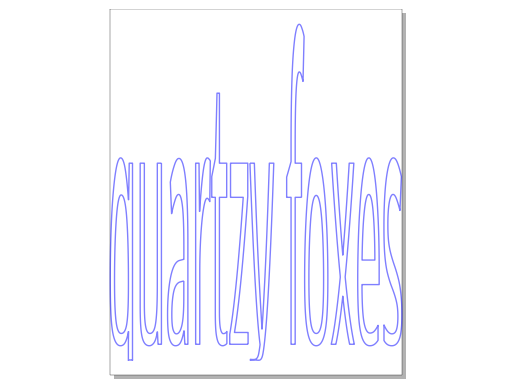

In [56]:
vsk = vsketch.Vsketch()
vsk.size("200mm", "250mm")
vsk.scale(f"1mm")
for pline in stretched:
    with vsk.pushMatrix():
        vsk.scale(32 / face.units_per_EM)
        vsk.polygon(pline)
vsk.display()

And in the next example, I apply a sine distortion to all points:

In [57]:
import math
plines = combine_plines(face, "quartzy foxes", resample_lines=True)
wavy = []
for pline in plines:
    mod_pline = []
    for pt in pline:
        mod_pline.append([pt[0] + math.sin(pt[1]*0.01)*25,
                          pt[1] + math.sin(pt[0]*0.01)*25])
    wavy.append(mod_pline)

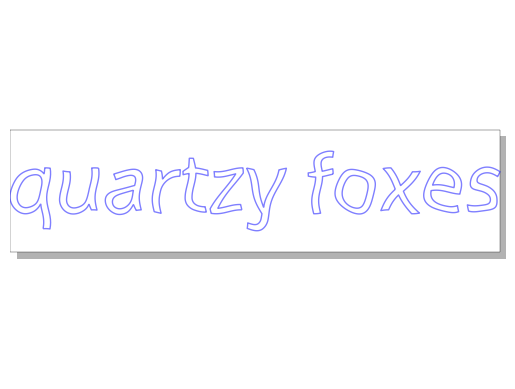

In [58]:
vsk = vsketch.Vsketch()
vsk.size("200mm", "50mm")
vsk.scale(f"1mm")
for pline in wavy:
    with vsk.pushMatrix():
        vsk.scale(32 / face.units_per_EM)
        vsk.polygon(pline)
vsk.display()

In the following example, I drop points at random:

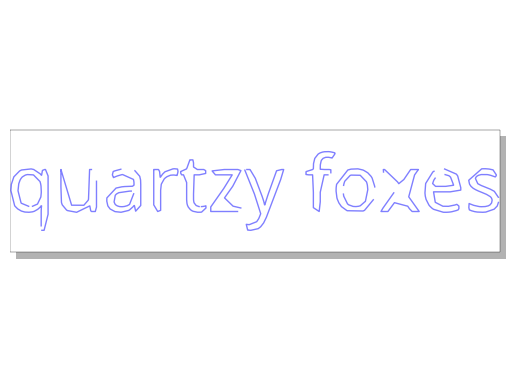

In [59]:
factor = 0.125
plines = combine_plines(face, "quartzy foxes", resample_lines=True)
choppy = []
for pline in plines:
    mod_pline = []
    for pt in pline:
        if uniform() < factor:
            mod_pline.append(pt)
    choppy.append(mod_pline)
vsk = vsketch.Vsketch()
vsk.size("200mm", "50mm")
vsk.scale(f"1mm")
for pline in choppy:
    with vsk.pushMatrix():
        vsk.scale(32 / face.units_per_EM)
        vsk.polygon(pline)
vsk.display()

## Getting the fills right

So far, we've been treating all contours as individual polygons. This is great if we only want to work with the outline of a glyph, but we may also want to work with the *filled shape* of the glyph. In reality, the contours in a font define spaces to be filled, not just individual polygons. In particular, in TrueType fonts, contours whose coordinates are specified in *counter-clockwise* order are considered to be cut-outs in the coordinates with *clockwise* order. So, in order to draw a filled shape, we need two things: (1) an abstraction of a polygon that allows for cut-outs; and (2) a method to determine whether the points in a polygon are in clockwise or counter-clockwise order.

> Note that we're working with "flipped" polygons in this notebook, where the Y coordinate increases moving down the page, which is the opposite of the coordinate system in the font itself! For that reason, we'll be treating counterclockwise as clockwise and clockwise as counterclockwise in the code snippets below.

The vsketch library doesn't come with these tools by default! We could program them ourselves, but we'd be better served to use a library that already has this functionality baked in. So we're going to use [Shapely](https://shapely.readthedocs.io/en/stable/index.html), a Python library developed primarily for [GIS](https://en.wikipedia.org/wiki/Geographic_information_system) but which is also useful for other kinds of computational geometry. If you installed vsketch, then you also already installed Shapely (it's one of vsketch's dependencies). Import it like so:

In [60]:
import shapely

Now I'm going to call the function above that turns a string into a list of contours from a TrueType font:

In [61]:
plines = combine_plines(face, "quartzy foxes", resample_lines=True)

... and convert each of those polylines to Shapely polygons:

In [62]:
polygons = [shapely.Polygon(item) for item in plines]

You can display a Shapely shape in vsketch by calling the `.geomtry()` method of the vsketch object:

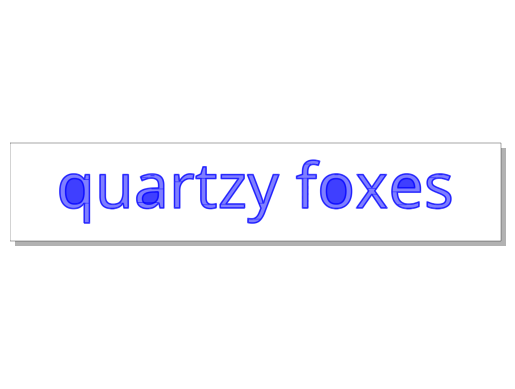

In [63]:
vsk = vsketch.Vsketch()
vsk.size("250mm", "50mm")
vsk.scale(f"1mm")
for item in polygons:
    with vsk.pushMatrix():
        vsk.scale(32 / face.units_per_EM)
        vsk.fill(1)
        vsk.geometry(item)
vsk.display()

Just converting our contour polylines to Shapely polygons isn't enough to solve the fill problem! What we need to do is determine which contours should be "cut out" of which other contours. The function in the following cell does just this. It converts the incoming list of polylines into Shapely polygons, and then categorizes them according to their clockwiseness using the `.is_ccw` attribute of Shapely polygons. For every clockwise polygon, the code finds the first counterclockwise polygon that contains it, and "subtracts" the first polygon from the second.

In [64]:
def cutout(plines):
    polygons = [shapely.Polygon(item) for item in plines]
    cw_polys = []
    ccw_polys = []
    for p in polygons:
        if p.exterior.is_ccw:
            ccw_polys.append(p)
        else:
            cw_polys.append(p)
    for p in cw_polys:
        for i in range(len(ccw_polys)):
            if ccw_polys[i].covers(p):
                ccw_polys[i] = shapely.difference(ccw_polys[i], p)
    return ccw_polys

Let's test it out! Here's a string with a bunch of meaty cutouts:

In [65]:
plines = combine_plines(face, "hi there BP®ꙮå", resample_lines=True)

Now we'll process it with the `cutout()` function:

In [66]:
processed = cutout(plines)

We've gone from 44 contours to 28 shapes:

In [67]:
len(plines), len(processed)

(44, 28)

And now we'll draw it. The fill actually works!!

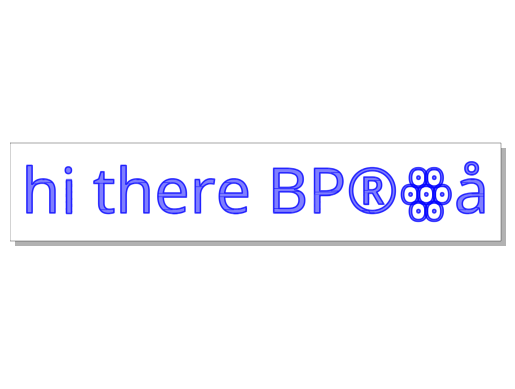

In [68]:
vsk = vsketch.Vsketch()
vsk.size("250mm", "50mm")
vsk.scale(f"1mm")
vsk.fill(1)
for item in processed:
    with vsk.pushMatrix():
        vsk.scale(32 / face.units_per_EM)
        vsk.geometry(item)
vsk.display()

### Messing with Shapely geometry (advanced)

Notes TK.

In [69]:
multipoly = shapely.MultiPolygon(processed)

In [70]:
wavy_mp = shapely.ops.transform(lambda x, y, z=None: [x+math.sin(y*0.01)*30, y+math.sin(x*0.01)*30], multipoly)

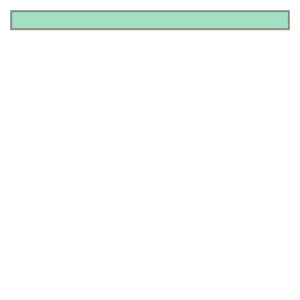

In [71]:
minx, miny, maxx, maxy = wavy_mp.bounds
slicer = shapely.Polygon([[minx, miny], [maxx, miny], [maxx, (miny+maxy)/2], [minx, (miny+maxy)/2]])
slicer

In [72]:
top = shapely.make_valid(wavy_mp).intersection(slicer)
bottom = shapely.make_valid(wavy_mp).difference(slicer)

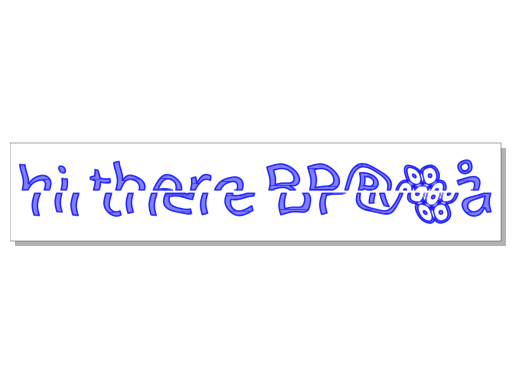

In [73]:
vsk = vsketch.Vsketch()
vsk.size("250mm", "50mm")
vsk.scale(f"1mm")
vsk.fill(1)
for item in top.geoms:
    with vsk.pushMatrix():
        vsk.scale(32 / face.units_per_EM)
        vsk.translate(-100, -25)
        vsk.geometry(item)
for item in bottom.geoms:
    with vsk.pushMatrix():
        vsk.scale(32 / face.units_per_EM)
        vsk.translate(100, 25)
        vsk.geometry(item)
vsk.display()

## Further resources

For a general introduction to digital typography, I highly recommend [Simon Cozen's *Fonts and Layout for Global Scripts*](https://simoncozens.github.io/fonts-and-layout/). The [history chapter](https://simoncozens.github.io/fonts-and-layout//history.html) is especially insightful and well-researched.

More on digital representations of typefaces:

* [UFO](http://unifiedfontobject.org/versions/ufo3/), a contemporary file format for fonts
* [FreeType Glyph
  Conventions](https://www.freetype.org/freetype2/docs/glyphs/index.html) is documentation for FreeType (a widely-used glyph rendering library), but also a good introduction to digital typography in general
* [An Introduction to TrueType Fonts: A look inside the TTF format](https://scripts.sil.org/cms/scripts/page.php?site_id=nrsi&id=IWS-Chapter08)
* [Bézier Curves and Type Design: A Tutorial](https://learn.scannerlicker.net/2014/04/16/bezier-curves-and-type-design-a-tutorial/)
* [Typography in 8 bits: System fonts](https://damieng.com/blog/2011/02/20/typography-in-8-bits-system-fonts)

Artworks engaging font data:

* [Leslie Mezei, Babel Shook](https://www.atariarchives.org/artist/sec7.php)
* [Eduardo Kac, Accident, 1994](http://www.ekac.org/accident.html)
* [Jürg Lehni & Alex Rich, Empty words, 2008](http://juerglehni.com/works/empty-words)
* [Zach Lieberman et al, IQ Font](http://thesystemis.com/projects/iq-font/)
* [BalletFont](https://web.archive.org/web/20160812072806/http://www.creativeapplications.net/openframeworks/balletfont-openframeworks/) ([making-of video](https://youtu.be/-DdAp26lmIU))